# Language Modelling

<a target="_blank" href="https://colab.research.google.com/github/LuisAngelMendozaVelasco/luisangelmendozavelasco.github.io/blob/master/_portfolio/IBM_AI_Engineering/portfolio-16.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

**Objective**: Create a Recurrent Neural Network focused on Language Modelling and reach low levels of perplexity on the Penn Treebank dataset.

[Language Modelling](https://en.wikipedia.org/wiki/Language_model) is the task of assigning probabilities to sequences of words. This means that, given a context of one or a sequence of words in the language the model was trained on, the model should provide the next most probable words or sequence of words that follows from the given sequence of words the sentence. This kind of analysis is very important for language-related tasks such as [Speech Recognition](https://en.wikipedia.org/wiki/Speech_recognition), [Machine Translation](https://en.wikipedia.org/wiki/Machine_translation), [Image Captioning](https://en.wikipedia.org/wiki/Automatic_image_annotation), Text Correction and many other very relevant problems. Language Modelling is one of the most important tasks in [Natural Language Processing (NLP)](https://en.wikipedia.org/wiki/Natural_language_processing).

For Language Modelling problems, [perplexity](https://en.wikipedia.org/wiki/Perplexity) is the way to gauge efficiency. Perplexity is simply a measure of how well a probabilistic model is able to predict its sample. A higher-level way to explain this would be saying that low perplexity means a higher degree of trust in the predictions the model makes. Therefore, the lower perplexity is, the better.

A [Recurrent Neural Network (RNN)](https://en.wikipedia.org/wiki/Recurrent_neural_network) is a type of artificial neural network designed to handle sequential data by incorporating feedback loops. Unlike traditional feedforward neural networks, RNNs process data across multiple time steps, allowing them to maintain a form of memory that captures information from previous inputs. This feature makes RNNs particularly useful for tasks involving text, speech, and time series data.

## Import libraries

In [1]:
import time
import collections
import os
import numpy as np
import tensorflow as tf
from keras import Sequential, Input, layers, optimizers, losses
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

2025-03-07 01:01:07.086081: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741330867.099724  383388 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741330867.103949  383388 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 01:01:07.117634: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Download the dataset

In [2]:
%%bash

wget -nc --progress=bar:force:noscroll http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz -P /tmp
tar -xf /tmp/simple-examples.tgz --skip-old-files -C /tmp

File '/tmp/simple-examples.tgz' already there; not retrieving.



## Load the dataset

Historically, datasets big enough for Natural Language Processing are hard to come by. This is in part due to the necessity of the sentences to be broken down and tagged with a certain degree of correctness, or else the models trained on it won't be able to be correct at all. This means that we need a large amount of data, annotated by or at least corrected by humans. This is, of course, not an easy task at all.

The [Penn Treebank](https://catalog.ldc.upenn.edu/docs/LDC95T7/cl93.html), or PTB for short, is a dataset maintained by the University of Pennsylvania. It is huge, there are over four million and eight hundred thousand annotated words in it, all corrected by humans. It is composed of many different sources, from abstracts of Department of Energy papers to texts from the Library of America. Since it is verifiably correct and of such a huge size, the Penn Treebank is commonly used as a benchmark dataset for Language Modelling.

The dataset is divided in different kinds of annotations, such as Piece-of-Speech, Syntactic and Semantic skeletons. For this example, we will simply use a sample of clean, non-annotated words (with the exception of one tag, <unk> , which is used for rare words such as uncommon proper nouns) for our model. This means that we just want to predict what the next words would be, not what they mean in context or their classes on a given sentence.

In [3]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# """Utilities for parsing PTB text files."""

def _read_words(filename):
    with tf.io.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()

def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id

def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)

    return [word_to_id[word] for word in data if word in word_to_id]

def ptb_raw_data(data_path=None):
    """Load PTB raw data from data directory "data_path".

    Reads PTB text files, converts strings to integer ids,
    and performs mini-batching of the inputs.

    The PTB dataset comes from Tomas Mikolov's webpage:

    http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz

    Args:
        data_path: string path to the directory where simple-examples.tgz has
        been extracted.

    Returns:
        tuple (train_data, valid_data, test_data, vocabulary)
        where each of the data objects can be passed to PTBIterator.
    """

    train_path = os.path.join(data_path, "ptb.train.txt")
    valid_path = os.path.join(data_path, "ptb.valid.txt")
    test_path = os.path.join(data_path, "ptb.test.txt")

    word_to_id = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    vocabulary = len(word_to_id)

    return train_data, valid_data, test_data, vocabulary, word_to_id

def ptb_iterator(raw_data, batch_size, num_steps):
    """Iterate on the raw PTB data.

    This generates batch_size pointers into the raw PTB data, and allows
    minibatch iteration along these pointers.

    Args:
        raw_data: one of the raw data outputs from ptb_raw_data.
        batch_size: int, the batch size.
        num_steps: int, the number of unrolls.

    Yields:
        Pairs of the batched data, each a matrix of shape [batch_size, num_steps].
        The second element of the tuple is the same data time-shifted to the
        right by one.

    Raises:
        ValueError: if batch_size or num_steps are too high.
    """

    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)

    for i in range(batch_size):
        data[i] = raw_data[batch_len * i:batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i * num_steps:(i + 1) * num_steps]
        y = data[:, i * num_steps + 1:(i + 1) * num_steps + 1]
        
        yield (x, y)

def id_to_word(id_list, word_to_id):
    line = []

    for w in id_list:
        for word, wid in word_to_id.items():
            if wid == w:
                line.append(word)

    return line

In [4]:
train_data, valid_data, test_data, vocabulary, word_to_id = ptb_raw_data("/tmp/simple-examples/data")

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(valid_data))
print("Number of test samples:", len(test_data))

Number of training samples: 929589
Number of validation samples: 73760
Number of test samples: 82430


## Visualize the dataset

The dataset is a list of words represented by numbers, e.g. [0, 1, 2, 3,...]. Let's look at a sequence of words and their corresponding number:

In [5]:
[str(number) + " -> " + word for number, word in zip(valid_data[:20], id_to_word(valid_data[:20], word_to_id))]

['1132 -> consumers',
 '93 -> may',
 '358 -> want',
 '5 -> to',
 '329 -> move',
 '51 -> their',
 '9836 -> telephones',
 '6 -> a',
 '326 -> little',
 '2476 -> closer',
 '5 -> to',
 '0 -> the',
 '662 -> tv',
 '388 -> set',
 '2 -> <eos>',
 '1 -> <unk>',
 '1 -> <unk>',
 '2974 -> watching',
 '2158 -> abc',
 "9 -> 's"]

## Build a Recurrent Neural Network

We have to convert the words in our dataset to vectors of numbers. The traditional approach is to use one-hot encoding method that is usually used for converting categorical values to numerical values. However, one-hot encoded vectors are high-dimensional, sparse and in a big dataset, computationally inefficient. 

We use [word embeddings](https://en.wikipedia.org/wiki/Word_embedding), which is a way of representing sentence structures or words as n-dimensional vectors (where n is a reasonably high number, such as 200 or 500) of real numbers. Basically, we will assign each word a randomly-initialized vector, and input those into the network to be processed. After a number of iterations, these vectors are expected to assume values that help the network to correctly predict what it needs to, in our case, the probable next word in the sentence. This is shown to be a very effective task in Natural Language Processing, and is a commonplace practice.

In [ ]:
class PTB_model(object):
    def __init__(self):
        ######################################
        # Setting parameters for ease of use #
        ######################################
        self.batch_size = 32 # The size for each batch of data
        self.num_steps = 20 # The total number of recurrence steps, also known as the number of layers when our RNN is "unfolded"
        self.hidden_size_l1 = 256 # The number of processing units (neurons) in the first hidden layer
        self.hidden_size_l2 = 128 # The number of processing units (neurons) in the second hidden layer
        self.vocab_size = 10000 # The size of our vocabulary
        self.embeding_vector_size = 200 # The size of the embedding vector
        self.max_grad_norm = 5 # Maximum permissible norm for the gradient (For gradient clipping -- another measure against Exploding Gradients)
        self._lr = 1.0 # Initial learning rate

        #####################################################
        # Initializing the model using keras Sequential API #
        #####################################################
        self._model = Sequential()

        ###############
        # Input layer #
        ###############
        self._input_layer = Input(batch_shape=(self.batch_size, self.num_steps)) # Define batch size
        self._model.add(self._input_layer)

        ####################################################################
        # Creating the word embeddings layer and adding it to the sequence #
        ####################################################################
        self._embedding_layer = layers.Embedding(self.vocab_size, self.embeding_vector_size, trainable=True)
        self._model.add(self._embedding_layer)

        ##########################################################################
        # Creating the LSTM cell structure and connect it with the RNN structure #
        ##########################################################################
        # This creates only the structure for the LSTM and has to be associated with a RNN unit still.
        # The argument  of LSTMCell is size of hidden layer, that is, the number of hidden units of the LSTM (inside A).
        # LSTM cell processes one word at a time and computes probabilities of the possible continuations of the sentence.
        lstm_cell_l1 = layers.LSTMCell(self.hidden_size_l1)
        lstm_cell_l2 = layers.LSTMCell(self.hidden_size_l2)

        # By taking in the LSTM cells as parameters, the StackedRNNCells layer junctions the LSTM units to the RNN units.
        # RNN cell composed sequentially of stacked simple cells.
        stacked_lstm = layers.StackedRNNCells([lstm_cell_l1, lstm_cell_l2])

        ############################################
        # Creating the input structure for our RNN #
        ############################################
        # Input structure is 20x[32x200]
        # Considering each word is represended by a 200 dimentional vector, and we have 32-batchs, we create 32 word-vectors of size [32x2000]
        # The input structure is fed from the embeddings, which are filled in by the input data
        # Feeding a batch of 32 sentences to a RNN:
        # - In step 1, first word of each of the 32 sentences (in a batch) is input in parallel.
        # - In step 2, second word of each of the 32 sentences is input in parallel.
        # The parallelism is only for efficiency.
        # Each sentence in a batch is handled in parallel, but the network sees one word of a sentence at a time and does the computations accordingly.
        # All the computations involving the words of all sentences in a batch at a given time step are done in parallel.

        ########################################################################################################
        # Instantiating our RNN model and setting stateful to True to feed forward the state to the next layer #
        ########################################################################################################
        self._RNNlayer = layers.RNN(stacked_lstm, return_sequences=True, return_state=False, stateful=True, trainable=True)

        # Define the initial state, i.e., the model state for the very first data point.
        # It initialize the state of the LSTM memory. The memory state of the network is initialized with a vector of zeros and gets updated after reading each word.
        self._initial_state = tf.Variable(tf.zeros([self.batch_size, self.embeding_vector_size]), trainable=False)
        self._RNNlayer.inital_state = self._initial_state

        ############################################
        # Adding RNN layer to keras sequential API #
        ############################################
        self._model.add(self._RNNlayer)

        ####################################################################################################
        # Instantiating a Dense layer that connects the output to the vocab_size and adding layer to model #
        ####################################################################################################
        self._dense = layers.Dense(self.vocab_size)
        self._model.add(self._dense)

        ####################################################################################################
        # Adding softmax activation layer and deriving probability to each class and adding layer to model #
        ####################################################################################################
        self._activation = layers.Activation('softmax')
        self._model.add(self._activation)

        ##########################################################
        # Instantiating the stochastic gradient decent optimizer #
        ##########################################################
        self._optimizer = optimizers.SGD(learning_rate=self._lr, clipnorm=self.max_grad_norm)

        ##############################################################################
        # Compiling and summarizing the model stacked using the keras sequential API #
        ##############################################################################
        self._model.compile(loss=self.crossentropy, optimizer=self._optimizer)
        self._model.summary()

    def crossentropy(self, y_true, y_pred):
        return losses.sparse_categorical_crossentropy(y_true, y_pred)

    def train_batch(self, _input_data,_targets):
        #################################################
        # Creating the Training Operation for our Model #
        #################################################
        # Create a variable for the learning rate
        self._lr = tf.Variable(0.0, trainable=False)
        # Get all TensorFlow variables marked as "trainable" (i.e. all of them except _lr, which we just created)
        tvars = self._model.trainable_variables

        # Define the gradient clipping threshold
        with tf.GradientTape() as tape:
            # Forward pass.
            output_words_prob = self._model(_input_data)
            # Loss value for this batch.
            loss = self.crossentropy(_targets, output_words_prob)
            # Average across batch and reduce sum
            cost = tf.reduce_sum(loss / self.batch_size)

        # Get gradients of loss wrt the trainable variables.
        grad_t_list = tape.gradient(cost, tvars)
        # Define the gradient clipping threshold
        grads, _ = tf.clip_by_global_norm(grad_t_list, self.max_grad_norm)
        # Create the training TensorFlow Operation through our optimizer
        self._optimizer.apply_gradients(zip(grads, tvars))

        return cost

    def test_batch(self, _input_data, _targets):
        ################################################
        # Creating the Testing Operation for our Model #
        ################################################
        output_words_prob = self._model(_input_data)
        loss  = self.crossentropy(_targets, output_words_prob)
        # Average across batch and reduce sum
        cost = tf.reduce_sum(loss / self.batch_size)

        return cost

    @classmethod
    def instance(cls):
        return PTB_model()

In [7]:
# Instantiates the PTB_model class
model = PTB_model.instance()

I0000 00:00:1741330434.509498  371964 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1430 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 20, 200)          │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (32, 20, 128)          │       665,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 20, 10000)        │     1,290,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (32, 20, 10000)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,955,088 (15.09 MB)

 Trainable params: 3,955,088 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [ ]:
#######################################################################################################################
# run_one_epoch takes as parameters the model instance, the data to be fed, training or testing mode and verbose info #
#######################################################################################################################
def run_one_epoch(model, data, is_training=True, verbose=False):
    # Define the epoch size based on the length of the data, batch size and the number of steps
    epoch_size = ((len(data) // model.batch_size) - 1) // model.num_steps
    start_time = time.time()
    costs = 0.
    iters = 0

    model._RNNlayer.inital_state = model._initial_state

    # For each step and data point
    for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.num_steps)):
        start_time_step = time.time()

        if is_training:
            loss = model.train_batch(x, y)
        else:
            loss = model.test_batch(x, y)

        # Add returned cost to costs (which keeps track of the total costs for this epoch)
        costs += loss

        # Add number of steps to iteration counter
        iters += model.num_steps

        steps_to_show = [0] + [i for i in range(int(epoch_size/10), epoch_size - int(epoch_size/10), int(epoch_size/10))]

        if verbose and step in steps_to_show:
            print(f"\tStep: {step + 1}/{epoch_size}")
            print(f"\t\telapsed time: {(time.time() - start_time_step):.3f}s - perplexity: {np.exp(costs / iters):.2f} - \
                  speed: {iters * model.batch_size / (time.time() - start_time):.2f} wps")
            print("\n") if step == steps_to_show[-1] else None
    
    # Returns the perplexity rating for us to keep track of how the model is evolving
    return np.exp(costs / iters)

In [9]:
epochs = 5
decay = 0.5 # The decay for the learning rate
max_epoch_decay_lr = 5 # The maximum number of epochs trained with the initial learning rate
learning_rate = 1.0 # Initial learning rate
train_perplexities = []
valid_perplexities = []

for i in range(epochs):
    # Define the decay for this epoch
    lr_decay = decay ** max((i + 1) - max_epoch_decay_lr, 0.0)
    dcr = learning_rate * lr_decay
    model._lr = dcr
    model._model.optimizer.learning_rate.assign(model._lr)
    start_time = time.time()
    
    print(f"Epoch {i + 1}/{epochs}:")
    # Run the loop for this epoch in the training mode
    train_perplexity = run_one_epoch(model, train_data, is_training=True, verbose=False)
    train_perplexities.append(train_perplexity)
    # Run the loop for this epoch in the validation mode
    valid_perplexity = run_one_epoch(model, valid_data, is_training=False, verbose=False)
    valid_perplexities.append(valid_perplexity)

    print(f"\telapsed time: {(time.time() - start_time):.3f}s - learning rate: {dcr:.2f} - perplexity: {train_perplexity:.2f} - val_perplexity: {valid_perplexity:.2f}")

Epoch 1/5:
	elapsed time: 282.622s - learning rate: 1.00 - perplexity: 383.32 - val_perplexity: 236.37
Epoch 2/5:
	elapsed time: 269.311s - learning rate: 1.00 - perplexity: 172.24 - val_perplexity: 170.01
Epoch 3/5:
	elapsed time: 270.345s - learning rate: 1.00 - perplexity: 129.46 - val_perplexity: 150.01
Epoch 4/5:
	elapsed time: 274.295s - learning rate: 1.00 - perplexity: 108.60 - val_perplexity: 141.73
Epoch 5/5:
	elapsed time: 261.806s - learning rate: 1.00 - perplexity: 95.90 - val_perplexity: 138.00


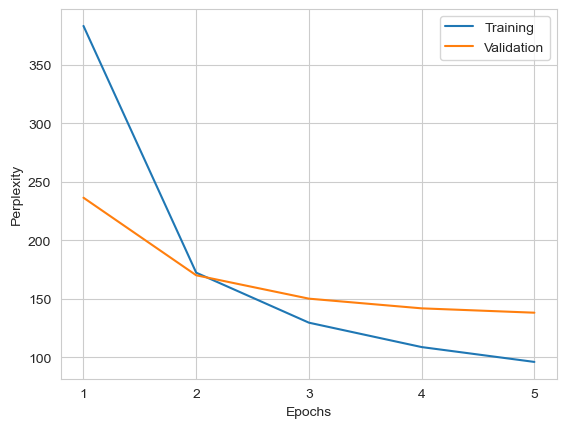

In [10]:
plt.figure()
plt.plot(train_perplexities)
plt.plot(valid_perplexities)
plt.xticks([i for i in range(epochs)], [i + 1 for i in range(epochs)])
plt.xlabel("Epochs")
plt.ylabel("Perplexity")
plt.legend(["Training", "Validation"])
plt.show()

# Evaluate the model

In [11]:
# See how effective was our training
test_perplexity = run_one_epoch(model, test_data, is_training=False, verbose=False)
pd.DataFrame(data={"Training set": [train_perplexity], "Validation set": [valid_perplexity], "Test set": [test_perplexity]}, dtype=float) \
.rename(index={0: 'Perplexity'}).round(2)

,Training set,Validation set,Test set
Perplexity,95.9,138.0,134.36
